# Import

In [2]:
import torch
import torchvision

import resource
# rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
# print(rlimit)
# resource.setrlimit(resource.RLIMIT_NOFILE, (1048576, rlimit[1]))
# print(rlimit)
import numpy as np
import os
import sys
import logging
import io
import time
import shutil
from tqdm import tqdm
from matplotlib.pyplot import imshow
import numpy as np
import torch
import torch.multiprocessing as multiprocessing
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from argparse import Namespace
from collections import OrderedDict
from scipy.sparse import coo_matrix
import socket
from datetime import datetime
from PIL import Image 
import json
import re
import hashlib
import subprocess
from copy import deepcopy, copy
from pprint import pprint
import torch.utils.data as data
from copy import copy
import json
from collections import namedtuple
from PIL import Image 
from torchvision import get_image_backend
from torch.utils.data.distributed import DistributedSampler
import torch.nn.init as weight_init
import csv
from glob import glob
import PIL
import pretrainedmodels
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_output_fname():
    return "%s_%s_%s" % (args.author, args.arch, get_hostname_timestamp_id())

def get_hostname_timestamp_id():
    return socket.gethostname() + '_' + re.sub(r'\W+', '', str(datetime.now()))

args = Namespace()
args.perm_dir = '/mnt/disks/imaterialist_fashion'
args.base_dir = '/mnt/ram-disk/imaterialist_fashion'
# args.data_dir = '/host/space/horita-d/dataset/ifoodchallenge2019'
args.data_dir = '/Users/daichi/Downloads/ifood'

args.input_dir = args.data_dir + os.sep + 'input'
args.output_dir = args.data_dir + os.sep + 'output'

args.train_dir = args.data_dir + os.sep + 'train_set'
args.val_dir = args.data_dir + os.sep + 'val_set'
args.test_dir = args.data_dir + os.sep + 'test_set'

args.train_labels_csv = args.data_dir + os.sep + 'train_labels.csv'
args.val_labels_csv = args.data_dir + os.sep + 'val_labels.csv'
# args.test_labels_csv = args.input_dir + os.sep + 'test_.csv'
args.debug_weights = False
args.test_overfit = False
args.num_labels = 251
args.batch_size = 64
# args.image_min_size = 256
args.image_min_size = 384
# args.nw_input_size = 224
args.nw_input_size = 331
args.num_workers = 32
args.imagenet_mean = [0.485, 0.456, 0.406]
args.imagenet_std = [0.229, 0.224, 0.225]
args.pretrain_dset_mean = args.imagenet_mean
args.pretrain_dset_std = args.imagenet_std

# args.arch = 'resnet101'
# args.arch = 'resnet152'
args.arch = 'pnasnet5large'
# args.fv_size = 2048
args.fv_size = 4320
args.pretrained = True
args.resume = False
args.start_epoch = 0
args.small=1e-12                         # small value used for avoiding div by zero
args.optimizer_learning_rate = 1e-4      # Adam optimizer initial learning rate
# args.optimizer_learning_rate = 1e-3      # Adam optimizer initial learning rate
args.scheduler_patience = 1              # Number of epochs with no improvement after which learning rate will be reduced
args.scheduler_threshold = 1e-6          # learning rate scheduler threshold for measuring the new optimum, to only focus on significant changes
args.scheduler_factor = 0.1        # learning rate scheduler factor by which the learning rate will be reduced. new_lr = lr * factor
args.earlystopping_patience = 1          # early stopping patience is the number of epochs with no improvement after which training will be stopped
args.earlystopping_min_delta = 1e-5      # minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement
args.evaluate = False
args.epochs = 50
args.print_details = False
args.print_freq = args.batch_size
args.ckpt_dir = args.output_dir + os.sep + 'ckpt'
args.ckpt = args.ckpt_dir + os.sep + 'ckpt_%s.pth.tar' % (args.arch,)
args.best = args.ckpt_dir + os.sep + 'best_%s.pth.tar' % (args.arch,)
args.num_output_labels = 3
args.sub_dir = args.output_dir + os.sep + 'submissions'
args.author = 'deccanlearners'
args.output_id = get_output_fname()
args.output_file = args.sub_dir + os.sep + 'output_%s.csv' %  args.output_id
args.params_file = args.sub_dir + os.sep + 'params_%s.json' % args.output_id
args.min_img_bytes = 4792

In [4]:
def mkdir_p(d):
    os.makedirs(d, exist_ok=True)

# Dataset

In [24]:
import torchvision.transforms as transforms

def create_transforms(args):
    train_tform = None
    if args.test_overfit:
        train_tform = transforms.Compose([
                                    transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                    std=args.pretrain_dset_std)
                                         ])
    else:
#         train_tform = transforms.Compose([transforms.RandomResizedCrop(args.image_min_size,
#                                                                        scale=(1.0, 1.0),
#                                                                        scale=(0.8, 1.2),
#                                                                        scale=(0.08, 1.0),
#                                                                        ratio=(3. / 4., 4. / 3.),
#                                                                        ratio=(float(args.nw_input_size) / float(args.image_min_size),
#                                                                               float(args.image_min_size) / float(args.nw_input_size)
#                                                                              ),
#                                                                        ratio=(1.0, 1.0),
#                                                                        interpolation=Image.BILINEAR
#                                                                       ),
#         train_tform = transforms.Compose([transforms.RandomAffine(0,
#                                                                   translate=(0., 0.),
#                                                                   translate=(0.25, 0.25),
# #                                                                   scale=(3. /4., 4. / 3.),
#                                                                   scale=(1., 1.),
#                                                                   shear=0,
#                                                                   shear=20,
#                                                                   resample=PIL.Image.BILINEAR,
#                                                                   fillcolor=0),
        train_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.TenCrop(args.nw_input_size),
                                          transforms.Lambda(lambda crops: crops[np.random.randint(len(crops))]),
                                          # TODO: Augmentation 追加(5/8)
                                        transforms.ColorJitter(hue=.05, saturation=.05),
                                          transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),

                                          
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=args.pretrain_dset_mean,
                                                               std=args.pretrain_dset_std)
                                         ])

    val_tform = transforms.Compose([transforms.Resize(args.image_min_size),
                                    transforms.CenterCrop(args.nw_input_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=args.pretrain_dset_mean,
                                                         std=args.pretrain_dset_std)
                                   ])
    return (train_tform, val_tform)

In [25]:
import pandas as pd
df = pd.read_csv(args.train_labels_csv)

In [26]:
import torch.utils.data as data
from copy import copy
import numpy as np

def parse_info(csv_path):
        df = pd.read_csv(csv_path)
        img_name = df['img_name'].tolist()
        label = df['label'].tolist()
        return (np.array(img_name), np.array(label))

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
      
class FoodDataset(data.Dataset):
        def __init__(self, root, csv_path, num_labels=250, transform=None, target_transform=None, test=False):
            self.root = root
            if not test:
                self.img_name, self.label = parse_info(csv_path)
            else:
                self.img_name = glob('{}/*.jpg'.format(root))
            self.num_labels = num_labels
            self.transform = transform
            self.test = test

        def __getitem__(self, index):
            if not self.test:
                img, label = self.img_name[index], self.label[index]
                img = '{}/{}'.format(self.root, img)
            else:
                img = self.img_name[index]
            
            # Make label
            zeros = torch.zeros(self.num_labels)
            if not self.test:
                zeros[label] = 1
            
            # Make img
            img = pil_loader(img)
            img = self.transform(img)
            
            return img, zeros

        def __len__(self):
            return len(self.img_name)
        
def imshow(img):
    denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    img = denorm(img).clamp_(0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [27]:
train_tform, val_tform = create_transforms(args)
print(train_tform)
print(val_tform)

Compose(
    Resize(size=384, interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    TenCrop(size=(331, 331), vertical_flip=False)
    Lambda()
    ColorJitter(brightness=0, contrast=0, saturation=0.05, hue=0.05)
    RandomRotation(degrees=(-20, 20), resample=2, expand=False)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=384, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(331, 331))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [28]:
train_dset = FoodDataset(args.train_dir, args.train_labels_csv, args.num_labels, transform=train_tform)
val_dset = FoodDataset(args.val_dir, args.val_labels_csv, args.num_labels, transform=val_tform)
test_dset = FoodDataset(args.test_dir, None, args.num_labels, transform=val_tform, test=True)

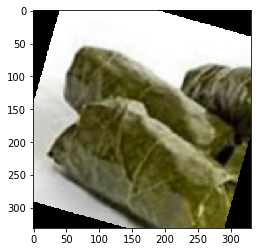

In [44]:
from random import randint
a, b = train_dset.__getitem__(randint(0, 100))
imshow(torchvision.utils.make_grid(a))

In [328]:
a, b = val_dset.__getitem__(randint(0, 100))
# imshow(torchvision.utils.make_grid(a))

In [326]:
a, b = test_dset.__getitem__(randint(0, 100))
# imshow(torchvision.utils.make_grid(a))

# DataLoader

In [331]:
train_loader = torch.utils.data.DataLoader(train_dset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           num_workers=args.num_workers,
                                           pin_memory=True,
                                          )
val_loader = torch.utils.data.DataLoader(val_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )

test_loader = torch.utils.data.DataLoader(test_dset,
                                         batch_size=args.batch_size,
                                         shuffle=False,
                                         num_workers=args.num_workers,
                                         pin_memory=True
                                        )

# Model

In [338]:
import torch.nn.init as weight_init

class FCWithLogSigmoid(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(FCWithLogSigmoid, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.logsigmoid = nn.LogSigmoid()
    
    def forward(self, x):
        return self.logsigmoid(self.linear(x))

def create_model(arch, num_labels=251, fv_size=2048,
                 pretrained=True, resume=False):
    models = pretrainedmodels
    if pretrained:
        print('=> Using pre-trained model `{}`'.format(arch))
        model = models.__dict__[arch](pretrained='imagenet+background')
    else:
        print('=> From schratch model `{}`'.format(arch))
        model = models.__dict__[arch]()
    model.last_linear = FCWithLogSigmoid(fv_size, num_labels)

    if arch.startswith('alexnet') or arch.starswith('vgg'):
        model.features = nn.DataParallel(model.features).cuda()
    else:
        model = nn.DataParallel(model).cuda()
    return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [340]:
model = create_model(args.arch,
                     num_labels=args.num_labels,
                     fv_size=args.fv_size,
                     pretrained=args.pretrained,
                     resume=args.resume,)

=> Using pre-trained model `pnasnet5large`


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/pnasnet5large-bf079911.pth" to /Users/daichi/.torch/models/pnasnet5large-bf079911.pth
  1%|          | 3653632/345153926 [00:10<16:40, 341484.87it/s]


KeyboardInterrupt: 